# Module: Introduction to Neural Networks
We start again with importing the modules and define some functions. Please evaluate the cells below and start reading the module below.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def make_cmap_plotter(colormap):
    def plotter(w, force_range = None, aspect=None):
        w = np.array(w)
        assert (w.ndim < 4), "w must have dimensionality less than 4"
        if (w.ndim == 0):
            w = np.array([[w]])

        if (w.ndim == 1):
            w = np.array([w])

        if (w.ndim == 2):
            if (force_range is None):
                w_range = np.abs(w).max()
            else:
                w_range = force_range
            plt.imshow(w, cmap=colormap, vmax=w_range, vmin=-w_range, aspect=aspect)    
            return

        grid_length = np.ceil(np.sqrt(w.shape[0]))

        for n in range(w.shape[0]):
            plt.subplot(grid_length,grid_length,n+1)
            vrange = np.abs(w).max()
            plt.imshow(w[n], cmap=colormap, vmax=vrange,vmin=-vrange, aspect=aspect)
            plt.title("n=%d" % (n+1))
    return plotter




def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def relu(x):
    return (x >= 0) * x

def arctan(x):
    return np.arctan(x)

## Introduction

Up until this point, we have specified the features used by our classifier manually. For example, we looked at moment features, fourier descriptors and color histograms. But, you might be wondering, can't we just let the computer decide what features are best? The answer to this question is generally yes, although it's not entirely that simple.

You may have heard about the field of "Deep Learning". Techniques developed in this field have achieved amazing performance on challenging tasks like identifying objects correctly in fairly unrestricted natural settings (for example, finding all traffic lights in a photo of a crossroads).

In this module and the next, we are going to give you a taste of deep learning. We will do this by showing you how to use existing models created by researchers, so that you have an idea of how such systems function. If you are interested in more detail, this will give you a foundation from which to find out more by yourself.

## Learning Feature Extraction and Classification Simultaneously

All our approaches up until now can be broken up into a system like the following:

![basic](figures/basic.svg)        

Up until now, we've hand-specified the feature extraction stage, and selected a classifier to learn based on these features. But, the process of selecting a good set of features is a bit trial-and-error. You might ask why we can't just learn the features themselves as well?

However, if we want to learn the features themselves, we run into a bit of a chicken and egg problem (seen from our current point of view):
- To learn the features, we need to know how they will be used during classification (so we need a trained classifier).
- To train the classifier, we need to have a set of features ready as the training set.

Are we stuck in this circular problem? Can we instead automatically learn the feature extraction and classifier stages? There are actually many approaches to this problem. In this module, we'll introduce you to an especially powerful method to do this. While the resulting system will be quite simple, there's a big payoff in learning about it. This module will introduce you to the foundation of deep learning, a family of methods that are currently the state of the art in many branches of machine learning. In short, deep learning is an extension of the above concept, where we then learn *multiple* stages of feature extraction and classification all at the same time. Seen from this perspective, it's easy to see how our smaller problem is relevant to deep learning, it is just the smallest case where there is only one feature extraction stage and one classifier stage. 

At this point, we have not yet identified how exactly this feature extraction will be performed. More specifically, how do we choose a feature extraction approach that can later be chained in multiple feature extraction stages? It turns out that nature provides a useful example, the human brain. Our brains work primarily by cells called neurons that fire electrical impulses over connections between them. Below is an example of such cells.

![neurons](figures/Chemical_synapse_schema_cropped.jpg)        




In the figure, you can see a neuron at the top which fires impulses to another neuron lower down. A neuron receives signals from other neurons through its dendrites. Based on the signals it receives, the neuron either fires an impulse or does not. When an impulse is fired, it travels down the neuron's axon to other neurons' dendrites. The process repeats itself at those neurons. The patterns of firing and not firing is the basic mechanism of thought processes.

How do these simple cells process high-level concepts like "car-ness" or "apple-ness"? We can look at the human visual system as an example of how this might work. Consider the following figures.


<table>
<tr>
    <td> <img src="figures/thorpe.jpg" alt="Drawing" style="width: 350px;"/> </td>
    <td> <img src="figures/scholarpedia-visual-cortex-HMAX-400px-Model.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr></table>




The visual system works by slowly but steadily making more informative features at each stage. At the bottom of the right-hand figure, an image is received on the retina of the eye. The signal then travels upwards, and is processed into more useful information at each stage. Firstly, edges are detected (hint: remember the convolutional edge detectors? They will become useful here). Based on these basic features, more complex elements like corners are extracted in the next layer. This process continues into higher-level layers where we begin to see patterns of activity associated with specific kinds of objects like cars and people. Based on these patterns, other regions of the brain can make decisions about these objects.

Putting aside the complex interactions of multiple neurons for now, we will start in the next section by looking at the case of a single neuron. It turns out that even a single neuron can perform surprisingly complex operations. In addition, some of the methods used to train a single neuron can be easily extended to train networks of such neurons (called neural networks).

# Training single neuron (logistic regression / single layer perceptron)

Before we can proceed, we need to find a mathematical model of a neuron that is easy to work with. Below is a figure of a real neuron.

![neuron](figures/Neuron.svg)        


Recall that the neuron receives signals from the dendrites, which may cause the neuron to fire. If the neuron fires, the electrical impulse travels through the axon and into the dendrite of subsequent cells.  Signals from some dendrites are excitory, meaning they tend to make the neuron fire, while signals from some dendrites are inhibitory, meaning they tend to make the neuron *NOT* fire. Each connection can have a different strength in terms of inhibition or excitation. 

It is the pattern of inhibition and excitation that allows a neuron to make complex decisions. As a simple example, think about a single neuron making a decision whether or not to pick an object up. Let's say there are two dendrites coming into the neuron. One of the dendrites comes from a neuron that fires if the object is a dangerous snake. The other dendrite comes from a neuron that fires if the object is a delicious bar of chocolate. The dendrite from the "dangerous snake" neuron would be inhibitory (it will try to inhibit the "picking up" neuron from firing so that the object is not picked up). The dendrite from the "delicious bar of chocolate" neuron would be excitory (it will try to make the "picking up" neuron fire so that the object is picked up).

The behaviour of real neurons is too complex. Instead, we can come up with a simpler model of a neuron that is easy to work with mathematically, but is still capable of complex behaviour. We start by drawing a diagram of this idealized neuron (called an artificial neuron).

![artificial neuron](figures/Single-Perceptron.png)        


In an artificial neuron, information flows from its inputs $x_1,\dots,x_n$. Each of these inputs $x_i$ is multiplied by a corresponding weight $w_i$. If the weight is positive, the input excites the neuron (the incoming signal is positive). If the weight is a negative number, the input inhibits the neuron (the incoming signal is negative). All the weighted inputs $w_ix_i$ are then added together which forms a number $z$ (the sigma $\Sigma$ just means we add each of the incoming signals from the left). So $$ z = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5$$


This number $z$ is then used as input for an so called activation function $\sigma$. More about this function below. The next block of gives a visualization of the process. It simulates a neuron that has 5 inputs. In this case the corresponding weights $w_1$ through $w_5$ are 2, 4, -2, 0 and 4 respectively. You can manipulate the input image using the sliders. The inputs vary from 0 (black) to 1 (white). 

To the right of the inputs, the weights $w_1,\dots,w_5$ are visualized. These get multiplied with the corresponding input on the left to produce the weighted input on the right. If the weight is positive (excitory), the color is red. If it is negative (inhibitory), the color is blue. If the weight is close to 0, it is white. You should become familiar with this color scheme, because we will use it to visualize weights throughout this module.

The weighted inputs are to the right of the weights. They are simply the corresponding input multiplied by its corresponding weight. Positive weighted inputs are plotted in green, negative weighted inputs are plotted in magenta.

On the far right is a curve showing the earlier mentioned activation function's output $\sigma(z)$. The role of the activation functions is that it puts the output of neuron between zero and one, and therefore, in some sense, into control. On the horizontal axis is $z$, recall that this is the sum of all the weighted inputs. The activation function itself is plotted in black, the output for the given input image is plotted as a big red dot. You may recognize the activation function as the sigmoid curve (also known as the logistic curve).

$$ a(z) = \frac{1}{1 + e^{-z}} $$

It's not important for you to remember the formula. What you need to know is this.
* The sigmoid output has a minimum of 0 and a maximum of 1. There is no limit to how negative or positive $z$ can be. That is, there is no limit to how much a neuron can be inhibited or stimulated. However, the neurons itself has an output limited between 0 and 1.
* Once a neuron is very stimulated extra stimulation does not change the output very much, this is already practically 1. Try to find out yourself if this is also the case for extra inhibition.
* The particular shape of the activation function corresponds to our intuition a neuron not firing at all, or a neuron firing at full strength. Any value in between 0 and 1 means the neuron is firing at partial strength.

Now evaluate the cell below and play a bit whit changing the inputs and take you understand what is visualized. Below are some concrete exercises to guide you.

In [2]:
weights_cmap = "bwr"
plot_weights = make_cmap_plotter(weights_cmap)

activations_cmap = "PiYG"
plot_activations = make_cmap_plotter(activations_cmap)

interact_activation = sigmoid
w = np.array([2, 4, -2, 0, -4])


def interact_neuron(x1 = (0.0, 1.0), x2=(0.0, 1.0), x3=(0.0, 1.0), x4=(0.0, 1.0), x5=(0.0, 1.0)):
    plt.rcParams["figure.figsize"] = (20,10)
    x = np.array([x1, x2, x3, x4, x5])
    z = w[0] * x[0] + w[1] * x[1] + w[2] * x[2] + w[3] * x[3] + w[4] * x[4]
    y = interact_activation(z)
    
    max_z = np.sum((w > 0) * w)
    min_z = np.sum((w < 0) * w)
    zs = np.linspace(min_z, max_z, 100)
    
    plt.subplot(1,6,1)
    plt.imshow(np.array([x]).T, cmap="gray", vmin=0.0, vmax=1.0)
    plt.title("Input Image (x)")
    for n in range(x.shape[0]):
        plt.gca().annotate("x[%d]=%.2f" % (n, x[n]), xy=(0,n), horizontalalignment='center', color="g")
    plt.axis("off")
    plt.subplot(1,6,2)
    plot_weights(np.array([w]).T)
    for n in range(w.shape[0]):
        plt.gca().annotate("w[%d]=%.2f" % (n, w[n]), xy=(0,n), horizontalalignment='center')
    plt.title("Pixel Weights (w)")
    plt.axis("off")
    plt.subplot(1,6,3)
    plot_activations(np.array([x*w]).T, force_range = max(max_z, -min_z))
    for n in range(w.shape[0]):
        plt.gca().annotate("x[%d]w[%d]" % (n, n), xy=(0,n-0.25), horizontalalignment='center')
        plt.gca().annotate("%.2f" % (x[n]*w[n]), xy=(0,n+0.25), horizontalalignment='center')
    plt.title("Weighted Inputs (x*w)")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.plot(zs, interact_activation(zs), 'k-')
    plt.plot([z],[y], 'ro',markersize=20)
    
    plt.title("Neuron Output: a = σ(np.sum(w * x)) = %f" % y)
    plt.ylabel("y = σ(z)")
    plt.xlabel("z = np.sum(w * x)")
    plt.legend(["σ(z)"])
    plt.grid()
    
    
interact(interact_neuron, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0)

interactive(children=(FloatSlider(value=0.0, description='x1', max=1.0), FloatSlider(value=0.0, description='x…

<function __main__.interact_neuron(x1=(0.0, 1.0), x2=(0.0, 1.0), x3=(0.0, 1.0), x4=(0.0, 1.0), x5=(0.0, 1.0))>

__Exercise(get to understand an artificial neuron)__:

First control individual inputs up and down again and answer the following questions:
1. What is the difference between the output neuron changes between inputs that correspond to red (positive) `w` values, and blue (negative) `w` values.
2. Describe the behaviour of the neuron with respect to the input corresponding to where `w` is zero (white).
3. How do the inputs with non-zero small `w` (light colored) behave in contrast to the non-zero large `w` (dark colored).
3. Based on the previous observations, can you describe what this particular neuron is "interested in" / "likes" when given an input image?

Now control all of the inputss to answer the following questions:
1. What configuration(s) of input values causes the output of the neuron to be highest?
2. What configuration(s) of input values causes the output of the neuron to be lowest? 
3. What configuration(s) of input values causes the output of the neuron to be exactly 0.5?


In the example above the weights are fixed. In learning problems the goal is to find or *learn* weights that enable you to make a classifyer.

# The MNIST Dataset

For our initial experiments with neural networks, we will make use of the MNIST dataset. This is a set handwritten images of digits. Have a look at the following image showing some examples:

![MNIST Examples](MnistExamples.png)



The MNIST database has been called the "fruit fly" of machine learning / vision, because it has historically often been used to test out new ideas for machine learning methods. It represents a fairly difficult problem, without being so complex that it takes forever run an experiment on it. We will make use of it to illustrate basic neural network concepts. 

Again we makse use of the learning package sklearn. It includes a comment "fetch_openml" which can download a variety of commonly used datasets. One of these is the MNIST dataset. The following block downloads the dataset, and stores the digit images in `X`, and the digits labels ('0', '1', ... , '9') in `y`.

In [5]:
import sklearn
from sklearn import datasets, svm, metrics

X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.0 # The images are in unsigned byte format (so, values range from 0 to 255). It's best to normalize to 0.0 to 1.0 (makes learning easier)

MemoryError: 

Let's look at y's shape

In [5]:
print(y.shape)

y

(70000,)


array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

As you can see, `y` has a length of 70000, meaning there are 70000 individual digit images in the database. You can see in the second line of the output that `y` is full of digit labels. Let's look at `X` now:

In [6]:
X.shape

(70000, 784)

Like `y`, the first dimension of `X` has a length of 70000. So, the number of digit images in `X` is consistent with the number of digit labels in `y`. Our first image should be given by

In [7]:
first_row = X[0]

print(first_row.shape)
print(y[0])

(784,)
5


You can see the first row has length 784, and it should be an image of the digit 5.

There's something strange here. The digits are one-dimensional, and have 784 elements.  Are these really images? Let's visualize the row as though it were an image with 784 columns, with only 1 row. We exaggerate the vertical dimension by adjusting the aspect ratio using `aspect=20.0` to make it easier to see the gray values.

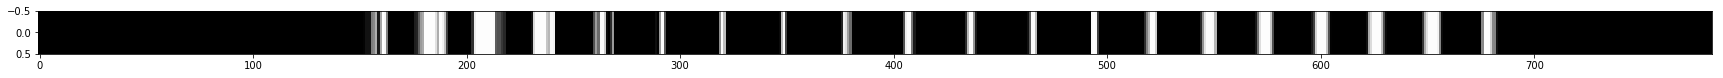

In [8]:
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow([first_row], cmap="gray", aspect=20.0)

Interesting ... There is clearly some structure here.  The digit images look like they have equal height and width, let's what the square root of 784 is.

In [9]:
np.sqrt(784)

28.0

Aha! 784 is exactly 28-by-28. We can take the first row as an example. What happens if we arrange the 784 values in a grid of 28 by 28? We can do this using numpy's reshape command

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.imshow(first_row.reshape((28,28)), cmap="gray")

To emphasise what we've just dicussed, look at the following block. With it, you can inspect individual rows in the image, and how each row corresponds to a section in the 784 pixel length dataset rows.

In [8]:
def interact_row(n=(0,27)):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplot(2,2,1)
    with_highlight = (first_row.reshape((28,28)))
    with_highlight = np.dstack([with_highlight,with_highlight,with_highlight]) / with_highlight.max()                     
    with_highlight[n:n+1, :, 1:] = 0.0
    plt.imshow(with_highlight)
    plt.subplot(2,2,2)
    plt.imshow(first_row.reshape((28,28))[n:n+1], cmap="gray")
    plt.subplot(2,1,2)
    plt.imshow(with_highlight.reshape(1, 28*28, 3), aspect=20.0)
    plt.show()
    
interact(interact_row)

interactive(children=(IntSlider(value=13, description='n', max=27), Output()), _dom_classes=('widget-interact'…

<function __main__.interact_row(n=(0, 27))>

So, now we know how the data is structured. X contains all the 70000 digits, which are actually images where the pixels have all been rearranged as a one-dimensional row of pixels. The reason why we do this is that many machine learning algorithms expect all the raw data for a single example should be contained in a one-dimensional row. Images are two-dimensional, so we need to use this trick to force them to be one-dimensional. Use the following code block to look at other digits in the MNIST dataset.

In [9]:
def interact_mnist(item=(0, X.shape[0]-1)):
    plt.imshow(X[item].reshape((28,28)), cmap="gray")
    plt.title("Digit: %s" % y[item])
    
interact(interact_mnist)

interactive(children=(IntSlider(value=34999, description='item', max=69999), Output()), _dom_classes=('widget-…

<function __main__.interact_mnist(item=(0, 69999))>

You can use the following cell to look at digits of a specific class

In [10]:
def interact_mnist(digit=(0,9), item=(0, 100)):
    plt.rcParams["figure.figsize"] = (6,6)

    of_digit = [x == str(digit) for x in y]
    selected_X = X[of_digit]
    plt.imshow(selected_X[item].reshape((28,28)), cmap="gray")
    plt.title("Digit: %d" % digit)
    
interact(interact_mnist)

interactive(children=(IntSlider(value=4, description='digit', max=9), IntSlider(value=50, description='item'),…

<function __main__.interact_mnist(digit=(0, 9), item=(0, 100))>

# Single Neuron Learning for MNIST (Logistic Regression)

Ultimately we would like to recognize any kind of number from MNIST. But it is very important to first get an idea of how a neuron might make a decision between alternatives. We start off with the problem of trying to distinguish the numbers 1 and 8. To do this, we first keep only examples of the digits 1 and 8 within the dataset.

In [11]:
# CAUTION: Make sure you set class 1 and 2 in the correct numerical order. So, class_1 = "3" and class_2 = "4" is fine, but class_1 = "4" and class_2 = "3" isn't. The code will still work if the
# order is switched, but then Scikit learn will internally switch the order, and that flips the weights, making talking about the weights and output classes a bit more difficult.
class_1 = "1"
class_2 = "8"

keepers = np.array([k == class_1 or k == class_2 for k in y])
print("Number of %s's and %s's together is %d" % (class_1, class_2, np.sum(keepers)))

Number of 1's and 8's together is 14702


In [12]:
splitpoint = 10000

train_X = X[keepers][:splitpoint]
test_X = X[keepers][splitpoint:]

train_y = y[keepers][:splitpoint]
test_y = y[keepers][splitpoint:]

Now we have a training and test set for just the digits 1 and 8. Let's build a model for classifying between 1 and 8. The case of a single neuron with a sigmoidal output is also known as Logistic Regression, and this is a special case the Scikit-learn implements. The following code creates the classifier and trains it.

In [13]:
lr_classifier = sklearn.linear_model.LogisticRegression(solver="sag",penalty='l2',multi_class="ovr", verbose=1, n_jobs=10, C=0.001)
lr_classifier.fit(train_X, train_y)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


convergence after 13 epochs took 1 seconds


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.0s finished


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=10,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

The code below allows you to interact with the classifyer. Note that the neuron has as many weights as inputs. We can therefore, also visualize the weights. Below you can pick different input images and see how the weighted image looks. On the right you see the result of the activation function. Play a bit around with the inputs and note down your observations.

In [14]:
def interact_two_class_model(n=(0, test_y.shape[0]-1)):
    plt.rcParams["figure.figsize"] = (20,10)
    x = test_X[n].reshape((28,28))
    w = lr_classifier.coef_.reshape((28,28))
    xw = x * w
    b = lr_classifier.intercept_
    z = np.sum(xw) + b
    y = interact_activation(z)
    #print(lr_classifier.predict_proba(test_X[n:n+1]))
    
    max_z = 6.0
    
    min_z = -6.0
    zs = np.linspace(min_z, max_z, 100)
    
    plt.subplot(1,6,1)
    plt.imshow(x, cmap="gray", vmin=0.0, vmax=1.0)
    plt.title("Input Image (x)")
    plt.axis("off")
    plt.subplot(1,6,2)
    plot_weights(w)
    plt.title("Pixel Weights (w)")
    plt.axis("off")
    plt.subplot(1,6,3)
    plot_activations(xw, force_range = np.max(np.abs(xw)))
    plt.title("Weighted Inputs (x*w)")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.plot(zs, interact_activation(zs), 'k-')
    plt.plot([z],[y], 'ro',markersize=20)
    plt.yticks([0,0.5,1])
    
    plt.title("Neuron Output: a = σ(np.sum(w * x) + b) = %f" % y)
    plt.ylabel("y = σ(z)")
    plt.xlabel("z = np.sum(w * x)")
    plt.legend(["σ(z)"])
    plt.grid()
    
    
interact(interact_two_class_model, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0)

interactive(children=(IntSlider(value=2350, description='n', max=4701), Output()), _dom_classes=('widget-inter…

<function __main__.interact_two_class_model(n=(0, 4701))>

TECHNICAL NOTE: If you looked carefully, you would have seen that the neuron output in this interactive dialog has output formula `a = σ(np.sum(w * x) + b)`, while the previous version had no `b` term. This term `b` is known as the bias, and it is simply a constant added to the signal coming from the weighted image pixels. This constant is determined during training, just like the weights are. The bias quantifies how much the neuron tends to fire all by itself with zero input signal. If the bias is negative, then the neuron needs a greater input activation to fire. If the bias is positive, the neuron already fires to some degree if the input is zero.

In Scikit Learn, the bias can be accessed using the `.intercept_` property. We haven't spoken about this because, while important mathematically, the input image weights are more important for gaining an intuition for how things work. Just keep in mind that, in practice, each neuron usually has such a bias. But, for the purposes of this notebook, you can safely ignore it.

Before continuing let's check how good the trained classifier is on unseen data. Recall that can be done using the confusion matrix.

In [15]:
test_predictions = lr_classifier.predict(test_X
                                        )

In [16]:
import sklearn.metrics

print(sklearn.metrics.confusion_matrix(test_y, test_predictions))

[[2437   38]
 [  78 2149]]


In [17]:
sklearn.metrics.accuracy_score(test_y, test_predictions)

0.9753296469587409

Those are some pretty impressive results! But, let's try and figure out how the logistic regression did this. First you need to recall that a neuron has a single weight associated with each input. Since there are $784 = 28\times 28$ inputs, there should be a corresponding $784$ weights. Sure enough, we can peek inside the logistic regression to get at its weights. The weights are accessed using `lr_classifier.coef_`. Let's first check the shape to see how many weights there are.

In [23]:
lr_classifier.coef_.shape

(1, 784)

Great, as expected, there are 784 weights. What the model is doing is taking each input pixel, multiplying it by the corresponding weight, add the result from all the inputs and then passing it through a sigmoid.

Now, recall that we can plot an input image with 784 pixels either as a one-dimensional row, or as a two-dimensional image. The following code block demonstrates this.

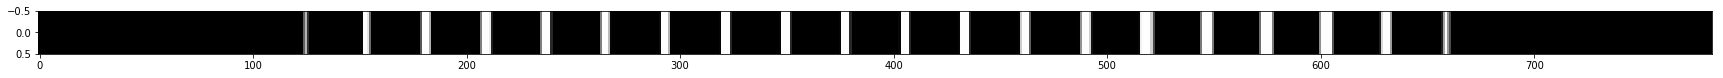

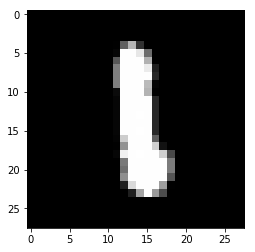

In [24]:
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow([test_X[0]], cmap="gray", aspect=20.0)
plt.show()
plt.rcParams["figure.figsize"] = (4,4)
plt.imshow(test_X[0].reshape((28,28)), cmap="gray")
plt.show()


But, we also have 784 weights, we can visualize these weights as a single row, or a 28x28 image as well!

In [25]:
plt.rcParams["figure.figsize"] = (30,30)

plot_weights(lr_classifier.coef_, aspect=20.0)
plt.show()
plt.rcParams["figure.figsize"] = (4,4)
plot_weights(lr_classifier.coef_.reshape((28,28)))
plt.show()


Remember that we are visualizing positive weights as red, they input through these weights excite the neuron, making the output go towards 1.0. Negative weights are visualized as blue, and input through these weights inhibit the neuron. 

Recall we chose '1' as class 1, and '8' as class 2. The Logistic Regression then learns weights so that, if you send in an image of a '1' (class 1), the output of the neuron is close to 0. If you send in an image of an '8' (class 2), the output of the neuron should be close to 1. Logistic Regression will choose class 1 ('1') if the neuron output is less than 0.5, and class 2 ('8') if the output of the neuron is more than 0.5.

Now look at the visualization of the weight above. Recall that white input pixels in red regions will tend to heighten the output of the neuron, and white input pixels in blue regions will tend to lower the output of the neuron. Think about the shape of 1's vs the shape of 8's. Look at the shapes of the blue and red regions in the weight visualization. Can you see how the blue regions might make the classifier choose class 1 ('1') and red regions make the classifier choose class 2 ('8')?

We can explore this more closely by doing some extra visualizations. In the following code block we visualize:
* Subplot 1: The mean of all images containing the digit '1'. This comes out as a blurry 1 (it is blurry because people write 1 in different ways).
* Subplot 2: The mean of all images containing the digit '8'. This also comes out as blurry because of individual differences in how people write 8.
* Subplot 3: We superimpose the mean image of '1' in the green channel with the mean image of '8' in the red channel. Red regions in this subplot correspond to regions where only the mean image of 1 is strong. Green regions correspond to regions where only the mean image of '8' is strong. Yellowish regions are located where both mean images are strong. Black regions are places where both mean images are weak.
* Subplot 4: We visualize (mean_image_2 - mean_image_1). Red regions are where the mean image of '8' is more positive (so the difference is positive). Blue regions are where the mean image of '1' is more positive (so the difference is negative).
* Subplot 5: The weights learned *automatically* by Logistic Regression.

Text(0.5, 1.0, 'Weights Learned by Logistic Regression')

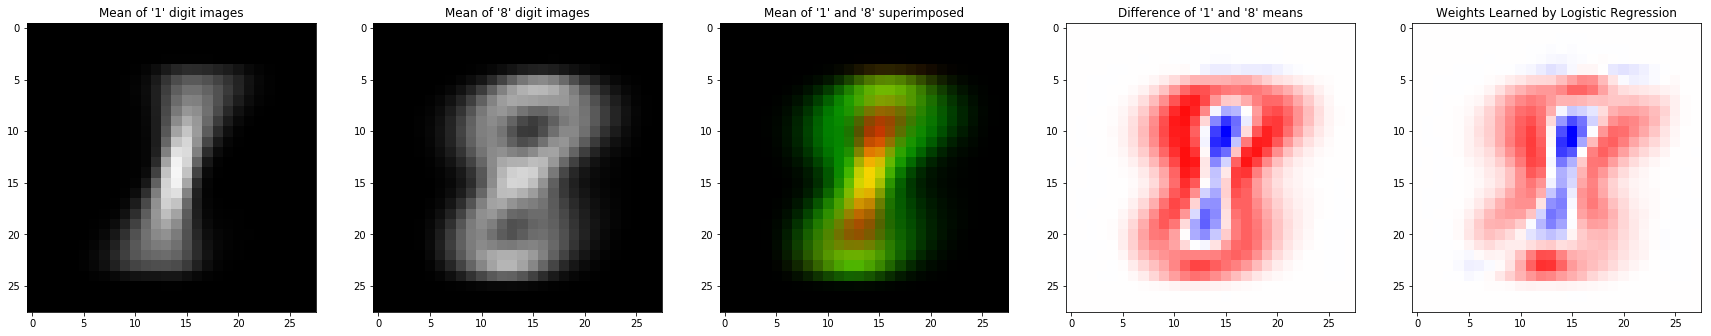

In [26]:
plt.rcParams["figure.figsize"] = (30,30)
class_1_mean = train_X[train_y == class_1].mean(axis=0)
class_2_mean = train_X[train_y == class_2].mean(axis=0)
mean_img_1 = class_1_mean.reshape((28,28))
mean_img_2 = class_2_mean.reshape((28,28))
plt.subplot(1,5,1)
plt.imshow(mean_img_1, vmin=0, vmax=1, cmap="gray")
plt.title("Mean of '%s' digit images" % class_1)
plt.subplot(1,5,2)
plt.imshow(mean_img_2, vmin=0, vmax=1, cmap="gray")
plt.title("Mean of '%s' digit images" % class_2)
plt.subplot(1,5,3)
plt.imshow(np.dstack([mean_img_1, mean_img_2, np.zeros_like(mean_img_1)]), vmin=0, vmax=1, cmap="gray")
plt.title("Mean of '%s' and '%s' superimposed" % (class_1, class_2))
plt.subplot(1,5,4)
plot_weights(mean_img_2 - mean_img_1)
plt.title("Difference of '%s' and '%s' means" % (class_1, class_2))
plt.subplot(1,5,5)
plot_weights(lr_classifier.coef_.reshape((28,28)))
plt.title("Weights Learned by Logistic Regression")



__Exercise__: Now, it is clear that the weights learned share aspects with the mean images of '1' and '8', but the weight visualization is neither an 1 or an 8. Can you describe why some regions of the mean image of '8' are included, but not others? Conversely, why are some regions of '1' included in the weights but not others?

Solution: Logistic regression learns non-zero weights exactly in those parts of the image where there is a strong contrast between the two digits classes. The loops on the left and right of the 8 are there because very few 1's have on pixels in those regions (notice that these regions are green in the superimposed image). Conversely, the vertical stripes of '1' tend to go through the center of the loops in 8's. So, the area inside the loops are strongly indicative of a '1' being present (notice the red in the superimposed regions. Weights are close to zero (faintly blue) in the center because the vertical stroke of '1's and the middle horizontal portion of '8's share this region (note the yellow in the superimposed images where the two mean channels both contribute).

# Single Neuron Learning for MNIST (All digits)

We now know how we can train a logistic regression to distinguish two kinds of digits. How do we do this for all ten digits instead? With a single logistic regression classifier, this doesn't work. However, if we use multiple logistic regression models, we can combine their results to decide between more than two classes.

We will now use the entire MNIST dataset, already in variables `X` and `y`. However, we haven't yet seperated them into training data and test data. There are 70000 digits in the dataset. Let's use all cases up to index 50000 for training, and use the rest for testing. The following code stores train data in `train_X` and `train_y`. Similarly, test data is stored in `test_X` and `test_y`.

In [27]:
splitpoint = 50000

train_X = X[:splitpoint]
test_X = X[splitpoint:]

train_y = y[:splitpoint]
test_y = y[splitpoint:]

Scikit-learn's implementation of logistic regression already includes the ability to classify more than 2 classes. We can create and fit our logistic regression model using the following code

In [28]:
lr_classifier = sklearn.linear_model.LogisticRegression(solver="sag",penalty='l2',multi_class="ovr", verbose=1, n_jobs=10, C=0.001, random_state=0)
lr_classifier.fit(train_X, train_y)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


convergence after 11 epochs took 22 seconds
convergence after 12 epochs took 24 seconds


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   24.2s remaining:  1.6min


convergence after 13 epochs took 26 seconds
convergence after 13 epochs took 26 seconds
convergence after 14 epochs took 26 seconds
convergence after 13 epochs took 26 seconds
convergence after 13 epochs took 27 seconds
convergence after 13 epochs took 27 seconds
convergence after 14 epochs took 27 seconds
convergence after 14 epochs took 27 seconds


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   26.9s finished


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=10,
          penalty='l2', random_state=0, solver='sag', tol=0.0001,
          verbose=1, warm_start=False)

Now, before we explain how Scikit-learn does the classification, let's look at the performance of the model.

In [18]:
test_predictions = lr_classifier.predict(test_X)

In [19]:
import sklearn.metrics

print(sklearn.metrics.accuracy_score(test_y, test_predictions))

0.9753296469587409


In [31]:
sklearn.metrics.confusion_matrix(test_y, test_predictions)

array([[1899,    0,    6,    6,    4,    8,   28,    4,   15,    1],
       [   0, 2138,    6,    7,    1,    8,    7,    2,   27,    3],
       [  17,   51, 1718,   33,   36,    4,   37,   45,   64,   17],
       [  10,   15,   38, 1793,    2,   67,   15,   24,   52,   24],
       [   1,   24,    7,    0, 1794,    4,   18,    3,   10,  104],
       [  28,   23,   15,  119,   32, 1448,   48,   20,   44,   30],
       [  19,   12,   14,    3,   20,   24, 1825,    1,    7,    0],
       [  13,   52,   41,    7,   26,    2,    2, 1912,    4,   59],
       [  18,   69,   25,   62,   17,   53,   20,   25, 1649,   45],
       [  24,   25,   11,   31,   88,   15,    3,   77,   11, 1685]],
      dtype=int64)

You should get a pretty decent score. MNIST is actually already a pretty challenging dataset to work with, so this is impressive for such a simple model.

Now, let's explain what Scikit-Learn is doing behind the scenes. Logistic regression can't directly classify between 10 classes. By specifying `multi_class="ovr"` in the line creating the logistic regression, we ask Scikit-Learn to create a so-called "one-vs-rest" model. The basic idea behind this strategy is that we can break the 10-class classification problem into 10 classification problems each with choosing between just two classes. Logistic regression handles two class classification problems, so we can use it in such a strategy. The classifiers are actually easy to understand
- Classifier 0: Is the digit 0 (class 2), or it is some other digit (1,2,3,4,5,6,7,8,9) (class 1).
- Classifier 1: Is the digit 1 (class 2), or it is some other digit (0,2,3,4,5,6,7,8,9) (class 1).
- Classifier 2: Is the digit 2 (class 2), or it is some other digit (0,1,3,4,5,6,7,8,9) (class 1).
...
- Classifier 9: Is the digit 9 (class 2), or it is some other digit (0,1,2,3,4,5,6,7,8) (class 1).

Now, recall that each logistic regression decides between class 1 and 2 by comparing the neuron output with 0.5. In a one-vs-rest strategy, we do something a bit different. We instead take the classifier which gives the biggest output and choose its corresponding digit as the result of the 10 class classification problem.

Another way to think about it is to pretend that each of the two-class classifiers are shouting "Pick me! Pick me!". The bigger the output of a classifier's neuron, the harder it is shouting. So, we end up choosing the classifier that shouts loudest. Because its output is the highest, it is most confident that the digit is the one it is associated with, and not one of the rest.

Now, we have 10 logistic regressions, so we should have 10 neurons each with 784 weights. We can actually access them using `lr_classifier.coef_`. Below you can see there are 10 sets of 784 weights in the one-vs-rest classifier.

In [32]:
lr_classifier.coef_.shape

(10, 784)

Let visualize the weights of each of the 10 neurons. Think a bit about the earlier exercise where we were classifying between '1' and '8'. But, instead, here we are classifying between a digit and all the rest. Red regions are those that favour the one digit (class 2), and blue regions are those favouring the rest of the digits (class 1).

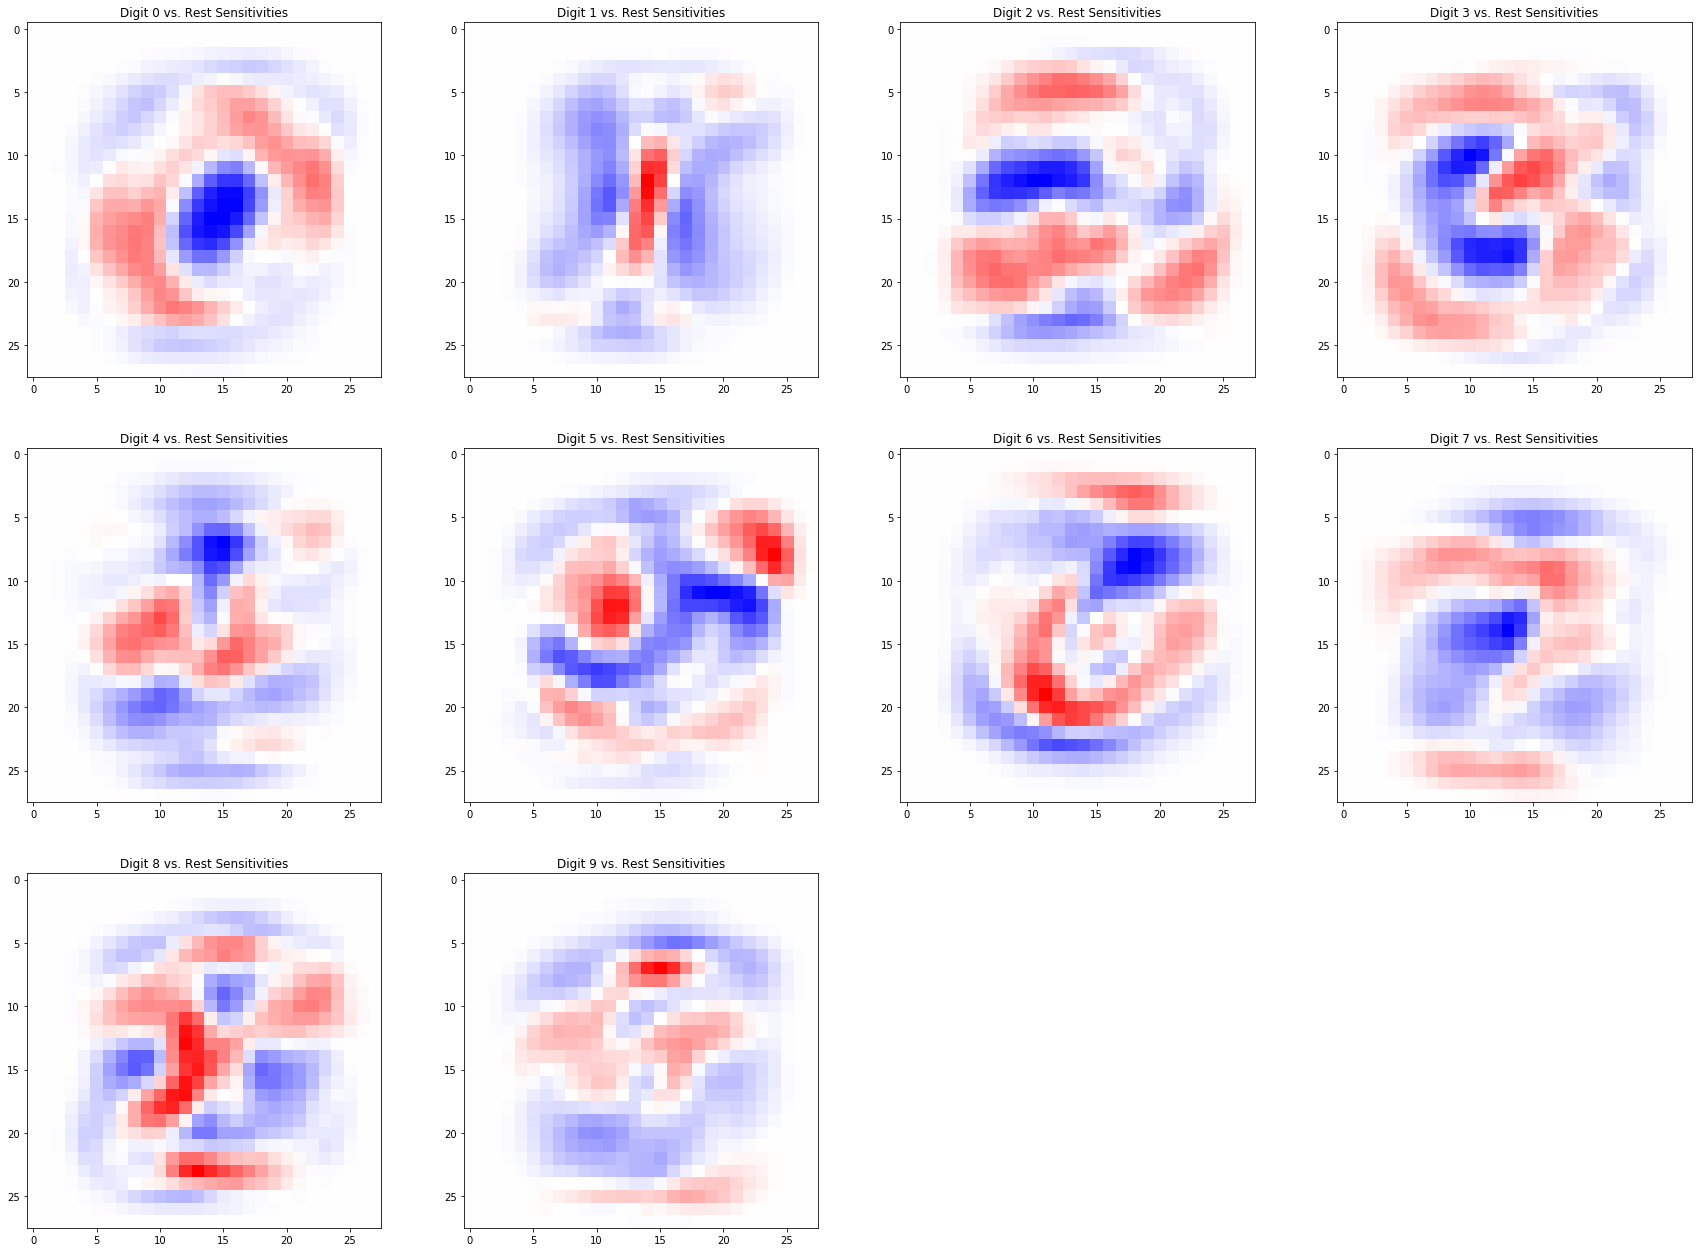

In [33]:
plt.rcParams["figure.figsize"] = (30,30)
for n in range(10):
    plt.subplot(4,4,n+1)
    vrange = np.abs(lr_classifier.coef_[n]).max()
    plt.imshow(lr_classifier.coef_[n].reshape((28,28)), cmap="bwr", vmax=vrange,vmin=-vrange)
    plt.title("Digit %s vs. Rest Sensitivities" % (lr_classifier.classes_[n]))


We can repeat our earlier analysis where we compared the means of '1's and '8's, except now we compare the mean of one digit versus the mean of all the other digits. The below code block repeats that visualization. Note that the mean is now really blurry, because it is averaging over 9 classes of digits. You will notice, though, that the "rest" mean does change a little depending on which class is missing from it. On the far right, we visualize the weights learned by the logistic regression specific to the selected digit. Pay attention to the contrasts between the mean of the specific digit and the mean of the rest of the digits. Examine how this translates into the weights learned by the logistic regression of that digit.

interactive(children=(IntSlider(value=4, description='digit', max=9), Output()), _dom_classes=('widget-interac…

<function __main__.interact_mnist(digit=(0, 9))>

C:\Anaconda3\envs\WURKS\lib\site-packages\matplotlib\image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Anaconda3\envs\WURKS\lib\site-packages\matplotlib\image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Anaconda3\envs\WURKS\lib\site-packages\matplotlib\image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Anaconda3\envs\WURKS\lib\site-packages\matplotlib\image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Anaconda3\envs\WURKS\lib\site-packages\matplotlib\colors.py:902: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Anaconda3\envs\WURKS\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


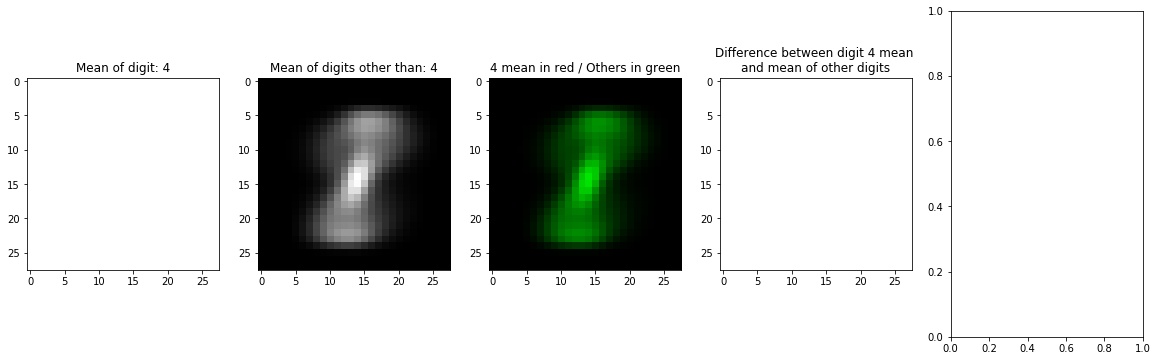

In [20]:
def interact_mnist(digit=(0,9)):
    plt.rcParams["figure.figsize"] = (20,6)

    of_digit = [x == str(digit) for x in train_y]
    not_of_digit = [x != str(digit) for x in train_y]
    the_mean = np.mean(train_X[of_digit], axis=0)
    #the_mean = the_mean / the_mean.max()
    not_mean = np.mean(train_X[not_of_digit], axis=0)
    #not_mean = not_mean / not_mean.max()
    diff = the_mean - not_mean
    plt.subplot(1,5,1)
    plt.imshow(the_mean.reshape((28,28)), cmap="gray")
    plt.title("Mean of digit: %d" % digit)
    plt.subplot(1,5,2)
    plt.imshow(not_mean.reshape((28,28)), cmap="gray")
    plt.title("Mean of digits other than: %d" % digit)
    plt.subplot(1,5,3)
    joint_image = np.dstack([the_mean.reshape((28,28)),not_mean.reshape((28,28)),np.zeros_like(the_mean.reshape((28,28)))]) 
    plt.imshow(joint_image)
    plt.title("%d mean in red / Others in green" % digit)
    plt.subplot(1,5,4)
    max_range = np.abs(diff).max()
    plt.imshow(diff.reshape((28,28)), cmap="bwr", vmin=-max_range, vmax=+max_range)
    plt.title("Difference between digit %d mean \nand mean of other digits" % digit)
    plt.subplot(1,5,5)
    vrange = np.abs(lr_classifier.coef_[digit]).max()
    plt.imshow(lr_classifier.coef_[digit].reshape((28,28)), cmap="bwr", vmax=vrange,vmin=-vrange)
    plt.title("Digit %s Sensitivities Learnt by Model" % (lr_classifier.classes_[digit]))
    
interact(interact_mnist)

Finally, we are ready to put it all together. The following code block shows the prediction process for each of the one-vs-rest models. The leftmost column is for digit-0-vs-rest, with the rightmost column being digit-9-vs-rest. The classifier output with the highest output is plotted with a large green dot (if the prediction is correct) or a large red cross (if the prediction is wrong). The rest of the classifier outputs are plotted as smaller black dots.

In [35]:
def interact_ten_class_model(n=(0, test_y.shape[0]-1)):
    plt.rcParams["figure.figsize"] = (30,10)
    x = test_X[n].reshape((28,28))
    
    predicted_class = np.argmax(lr_classifier.predict_log_proba(test_X[n:n+1])[0])
    correct_prediction = test_y[n][0] == lr_classifier.predict(test_X[n:n+1])[0]
    
    for n_class in range(10):
        w = lr_classifier.coef_[n_class].reshape((28,28))
        xw = x * w
        b = lr_classifier.intercept_[n_class]
        z = np.sum(xw) + b
        y = interact_activation(z)
        #print(lr_classifier.predict_proba(test_X[n:n+1]))

        max_z = 6.0 
        min_z = -6.0
        zs = np.linspace(min_z, max_z, 100)

        plt.subplot(6,10,1 + n_class)
        plt.imshow(x, cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Input %s (x)" % test_y[n])
        plt.axis("off")
        plt.subplot(6,10,11 + n_class)
        plot_weights(w)
        plt.title("Weights (w%d)" % n_class)
        plt.axis("off")
        plt.subplot(6,10,21 + n_class)
        plot_activations(xw, force_range = np.max(np.abs(xw)))
        plt.title("Weighted (x*w%s)" % n_class)
        plt.axis("off")
        plt.subplot(2,10,11 + n_class)
        plt.plot(zs, interact_activation(zs), 'k-')
        if (n_class == predicted_class):
            if (correct_prediction):
                plt.plot([z],[y], 'go',markersize=14)
            else:
                plt.plot([z],[y], 'rx',markersize=14,markeredgewidth=4)
        else:
            plt.plot([z],[y], 'ko',markersize=7)
        plt.yticks([0,0.5,1])

        plt.title("Class %d => %f" % (n_class,y))
        #plt.ylabel("y = σ(z)")
        plt.xlabel("z = np.sum(w%s * x + b%s)" % (n_class, n_class))
        plt.grid()
    
    
interact(interact_ten_class_model, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0)

interactive(children=(IntSlider(value=9999, description='n', max=19999), Output()), _dom_classes=('widget-inte…

<function __main__.interact_ten_class_model(n=(0, 19999))>

# The Problem With "Shallow" Learning



While the logistic regression model clearly learnt sensible connection strengths, there is something unsatisying about the way in which it operates. Arguably, it's not doing much more than seeing whether or not the input differs substantially from the mean of the other digits. That's not particularly smart (although it does work quite well already on MNIST). There is also a somewhat subtler problem in the way it functions.

The following code is similar to the row visualization done before, except it allows you to move the digit 5 up and down as well. Play around a bit with moving the digit along the y-axis, and look at the "flattened" version of all the rows below it.

In [36]:
def interact_row(n=(0,27), offset=(-27,27)):
    plt.subplot(3,1,1)
    with_highlight = (first_row.reshape((28,28))) 
    X, Y = np.meshgrid(range(28), range(28))
    Y = (Y + offset) % 28
    with_highlight = with_highlight[Y,X]
    with_highlight = np.dstack([with_highlight,with_highlight,with_highlight]) / with_highlight.max()                     
    with_highlight[n:n+1, :, 1:] = 0.0
    plt.imshow(with_highlight)
    plt.subplot(3,1,2)
    plt.imshow(first_row.reshape((28,28))[n:n+1], cmap="gray")
    #plt.rcParams["figure.figsize"] = (30,30)
    plt.subplot(3,1,3)
    plt.imshow(with_highlight.reshape(1, 28*28, 3), aspect=20.0)

plt.rcParams["figure.figsize"] = (20,6)
    
interact(interact_row)

interactive(children=(IntSlider(value=13, description='n', max=27), IntSlider(value=0, description='offset', m…

<function __main__.interact_row(n=(0, 27), offset=(-27, 27))>

Notice that just by moving even one pixel up or down, there is a dramatic difference in which pixels in the flattened version of the digit are on or off. If you were to look more closely, you would see that the on pixels themselves were also moving slightly to right and left.

Why is this such a problem? The issue is basically that logistic regression sees every pixel as a completely different unrelated entity. It has no concept of pixels being near or distant from each other. Logistic regression does learn, to some extent, that it should react to neighbouring pixels in a similar way, but this is still fairly brittle. It also means that logistic regression can't really do sophisticated decisions, it has to work directly with the pixels, which aren't that informative all by themselves.

So, we currently have the following kind of system.

Image pixels => Logistic regressions for classifier decision

But, what if we could add an extra phase in between, something like the following:

Image pixels => Has an upper loop?, has a lower loop?, has a vertical stripe in middle?, has a horizontal strip in middle? => classifier decision

So, we at the end the classifier has more informative features than individual pixels to base its decision on. If the image contains a loop above and a loop below, it is probably an 8. If the image has a single vertical strip in the middle, it's probably a 1, and so on.

This is a fine idea, but how do we do this? We certainly wouldn't want to write individual functions to detect loops or stripes, we want the machine to decide by itself what features would be useful. Fortunately, there is a way we can do this. We know that a logistic regression can detect a specific combination of pixels, why not instead a specific combination of loops or lines? We also know a logistic regression can learn to detect groups of informative pixels in the input, so perhaps we can use them to detect loops or vertical lines (etc.).

Our system will look like this:

Image pixels => Logistic regressions that look for things like loops and lines => Logistic regressions for classifier decision

A system with multiple layers of logistic regressions is actually a kind of neural network. So, you are already familiar with how the individual components of a neural network operate.

Let's illustrate these ideas in more detail. The following figure illustrates how a multi-class logistic regression looks when applied to MNIST. There is an input layer of $784$ units where the input image is applied. After that, there is the output layer with the 10 neurons for each digit. Each output neuron is connected to all of the input neurons directly, with each connection having a corresponding weight.

![logistic regression_mnist](figures/lr_mnist.png) 

Our description just now of a neural network made of an extra intermediate stage of logistic regressions can be depicted as follows.

![neural_network_mnist](figures/nn_mnist.png)

Here it is important to note that the only difference is that there is now a extra layer in the middle, called a hidden layer. The hidden layer in this figure contains 15 units, but this can actually be set to any number you would like, and this choice can influence the performance greatly. Like the original logistic regression, each of the neurons in the hidden layer is connected to all the input pixels. The output layer is still there, but now each output neuron connects to each neuron in the HIDDEN layer instead. So, you can imagine that each of the hidden units has a set of weights just like the original logistic regression that we can visualize as a grid of reds, blues and whites. These weights will show what each hidden neuron is interested in within the input image. The output neurons then don't make decisions directly on the input pixels, but on the outputs of these hidden neurons instead. 

What do we gain by this change? Basically, because we aren't trying to make decisions about the output class directly, the hidden units allow us to first look for interesting aspects in the input image that may be useful for many of the output neurons. Again, think about the example we gave earlier. Some of the hidden units might specialize in finding loops in the input image (a loop in the top, or a loop in the bottom). Some might specialize on lines (for example, a vertical line). The output neurons then get to put these features together into a higher level decision. The output 1 might see a vertical line as an excitation (given that a one is usually just a vertical line), but would be inhibited by the presence of either a top loop or a bottom loop (which could indicate a 6, a 9 or an 8). The output 9 might see a vertical line and a loop at the top as an excitation, but a lower loop would be inhibiting (since that suggests a 6 or an 8 instead).

Another gain we've made is that we could potentially look for an unlimited amount of these kinds of features. The model will learn a set of weights for each of the hidden units. So, each hidden unit added will provide the flexibility of one more high-level feature for the output layer to work with. In reality, it turns out that we shouldn't add too many hidden units, since a model with too much capacity can learn to just remember the training examples instead of learning principles that help it operate on the unseen test data (this phenomenon is called "overfitting"). But, we now have the option of choosing how many hidden units to use, while in the original logistic regression we were stuck with 10 neurons (one for each output class). 

While it is not immediately obvious how we can train all the logistic regressions in the system simultaneously, this turns out to be actually quite simple (making use of techniques from calculus). We won't discuss these methods, we'll instead use prewritten implementations of them. We will instead discuss what the final trained system looks like, and get an idea of why it works.

Fortunately, scikit-learn implements this particular kind of neural network already, and we can almost reuse our previous code as is. We're first going to setup the neural network first, and analyse its performance. This will illustrate how simple it is to switch between different kinds of models in Scikit-learn, you basically just choose a different classifier and the rest of the analysis code does not need changing.

The following code block allows you to either train a neural network, or load a neural network that we pretrained for you from disk. You can choose between training a new model, or loading a model from disk, by setting `use_pretrained` to `False` or `True` respectively. We've set it to `True` by default, because we would like to discuss an existing model with you to illustrate some concepts.

In [37]:
import sklearn.neural_network
import pickle

use_pretrained = True

if (use_pretrained):
    pickle_filename = "nn_mnist_weights.pickle"
    weight_pickle = open(pickle_filename, "rb")
    nn_classifier = pickle.load(weight_pickle)
    weight_pickle.close()
    num_hidden = nn_classifier.hidden_layer_sizes[0]
    print("Number of hidden units is %d" % num_hidden)
else:    
    num_hidden = 25

    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, 
    #                 learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
    #                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

    nn_classifier = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(num_hidden, ), activation="logistic", alpha=0.1, solver='adam', early_stopping=True, batch_size=50, random_state=0)
    nn_classifier.fit(train_X, train_y)

Number of hidden units is 25


The following code block illustrates how we saved the neural network model. Just leave `save_trained_model` as `False`, this code block is only here that you know how to save a model if you'd like in the future.

In [38]:
import pickle

save_trained_model = False # Warning, setting this to true will overwrite the existing pretrained weights.

if save_trained_model:
    weight_pickle = open("nn_mnist_weights.pickle", "wb")
    pickle.dump(nn_classifier, weight_pickle)
    weight_pickle.close()

Now, let's make some predictions and determine how well the model is doing. The following code blocks calculate the confusion matrix and the accuracy of the classifier.

In [39]:
nn_test_predictions = nn_classifier.predict(test_X)


In [40]:
import sklearn.metrics

print("Accuracy = %f" % sklearn.metrics.accuracy_score(test_y, nn_test_predictions))

Accuracy = 0.929200


In [41]:
sklearn.metrics.confusion_matrix(test_y, nn_test_predictions)

array([[1911,    0,    1,    3,    1,   10,   22,    5,   17,    1],
       [   0, 2152,    5,    5,    1,    7,    5,    3,   20,    1],
       [  16,   14, 1826,   17,   18,    7,   29,   23,   62,   10],
       [   7,    6,   28, 1820,    1,   76,    9,   19,   56,   18],
       [   1,   16,    7,    1, 1846,    1,   19,    5,    7,   62],
       [  15,    9,   16,   52,   14, 1611,   32,    8,   41,    9],
       [  13,    5,    9,    0,   11,   15, 1861,    1,   10,    0],
       [   7,   35,   29,    4,   20,    2,    0, 1966,    3,   52],
       [   9,   41,   13,   25,   12,   36,   13,   15, 1802,   17],
       [  16,   15,    4,   20,   59,   17,    1,   32,   17, 1789]],
      dtype=int64)

__Exercise__: Compare the performance with the accuracy and confusiuon matrix for a single logistic regression format. Did it get better?

Solution:The accuracy and confusion matrix above is likely (though not certain), to be noticeably better than the single logistic regression (at the time of writing, 93% vs. 89%). However, neural networks are capable of much better results, we're just starting off with a simple variation to illustrate how such networks function.

To get an idea how the neural network operates, let's visualize the weights of the hidden units. This is no different from how we visualized the weights of the earlier logistic regression. The only difference is that the weights aren't being used *directly* to make a classification decision. That role is left to the output layer, which can monitor combinations of hidden unit activities that they find useful in making a decision.

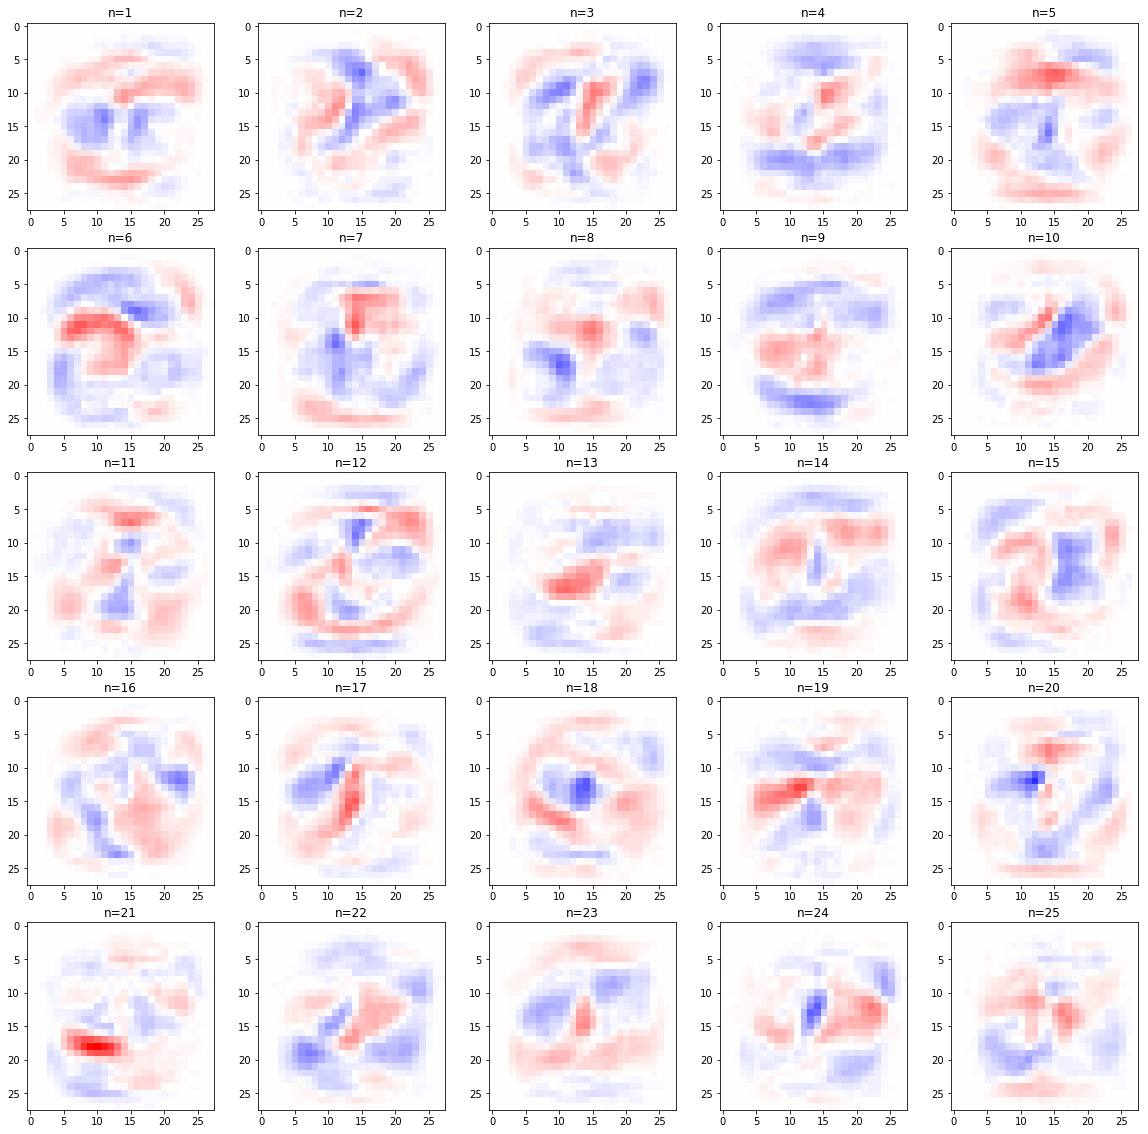

In [42]:
plt.rcParams["figure.figsize"] = (20,20)

grid_length = np.ceil(np.sqrt(num_hidden))

plot_weights(nn_classifier.coefs_[0].T.reshape((-1,28,28)))

#for n in range(num_hidden):
#    plt.subplot(grid_length,grid_length,n+1)
#    vrange = np.abs(nn_classifier.coefs_[0]).max()
#    plt.imshow(nn_classifier.coefs_[0][:,n].reshape((28,28)), cmap="bwr", vmax=vrange,vmin=-vrange)
#    plt.title("Hidden unit %d" % (n+1))


Looking at the hidden layer weights, none of them are obviously associated with a particular digit. This is because each hidden unit is used by multiple digit output classifiers in making decisions. So, the weights in the hidden layer are not similar to the digits themselves, but instead are building blocks from which digit detectors can be built.

Hidden layer weights also don't necessarily look for obvious features that might be useful for humans in conciously making a decision (even though we might unconciously use similiar features in our early visual system). But, there is visible structure in the weights. This is because the weights determined automatically for their effectiveness in helping the output units make their decisions. The training algorithm isn't looking for features that a human might find pleasing.

However, we can still interpret the weights. For a given hidden unit, red regions indicate that the unit wants to fire if it sees pen strokes in those regions. Blue regions indicate that the hidden unit is inhibited from firing if there are pen strokes in those regions. So, hidden units are contrasting areas of the input image. Please note that the output units can weight a hidden unit either positively or negatively, so the exact *sign* (redness or blueness) doesn't matter, what matters is the *contrast* between red regions and blue regions.  

As an example of interpreting weights, consider unit $n=21$ in the pretrained weights. It is obviously very interested in a small horizontal region in the bottom left of the image. This unit could be trying to detect strokes that look like this, but that would not be very powerful, as people could easily make their horizontal stroke a bit higher or lower. Instead, it is more likely the hidden unit could be testing whether a *vertical* stroke is passing through that region (since people would make the vertical stroke at slightly different x locations, the unit tests a small range of x values for this vertical stroke). Think for example of the lower left part of a 6 or 0, which do have such a stroke, and contrast with say a 5 or a 9, which do not.

__Exercise__: Write down similar arguments for some of the other hidden unit weights?

In the following code block, we visualize how a given image interact with each hidden unit. Again, patterns of activity are plotted in green and magenta. Green means the input times the weight is positive (excitory), magenta means the input times the weight is negative (inhibitory). Notice how each hidden unit responds to different parts of the image. Also note the difference in how the hidden units react to different digit types.

In [50]:
def interact_nn_activations(n=(0, test_X.shape[0]-1)):
    plt.rcParams["figure.figsize"] = (30,10)

    grid_length = np.ceil(np.sqrt(num_hidden))
    x_img = test_X[n].reshape((-1, 28,28))
    
    coeffs = nn_classifier.coefs_[0].T.reshape((-1,28,28))
    weighted = x_img * coeffs

    n_units = nn_classifier.intercepts_[0].shape[0]
    
    sums = np.sum(weighted, axis=(1,2))
    hidden_outputs = sigmoid(sums + nn_classifier.intercepts_[0])
        
    #X.dot(nn_classifier.coefs_[0]) + nn_classifier.intercepts_[0].reshape((n_units,))
    
    grid_length = int(np.ceil(np.sqrt(num_hidden)))

    grid_sums = np.zeros((grid_length * grid_length))
    grid_sums[:sums.shape[0]] = sums
        
    grid_outputs = np.zeros((grid_length * grid_length))
    grid_outputs[:sums.shape[0]] = hidden_outputs
    
    plt.subplot(1,3,2)
    vrange = np.abs(grid_sums).max()
    plt.imshow(grid_sums.reshape((grid_length, grid_length)), cmap=activations_cmap, vmin=-vrange, vmax=vrange)
    plt.title("Total activity from hidden units")
    plt.subplot(1,3,3)
    vrange = np.abs(grid_outputs).max()
    plt.imshow(grid_outputs.reshape((grid_length, grid_length)), cmap="gray", vmin=0, vmax=1)
    plt.title("Output from hidden units")
  
    m = -1
    row = -1
    for n in range(num_hidden):
        m = (m + 1) % grid_length
        if (m == 0):
            row = row + 1
        
        plt.subplot(grid_length,3*grid_length,m + row * 3*grid_length + 1)
        plt.gca().axis("off")
        vrange = np.abs(weighted).max()
        plt.imshow(weighted[n], cmap=activations_cmap, vmax=vrange,vmin=-vrange)
        #plt.title("Hidden unit %d" % (n+1))
    
    #plot_activations(weighted)
    
interact(interact_nn_activations)

interactive(children=(IntSlider(value=9999, description='n', max=19999), Output()), _dom_classes=('widget-inte…

<function __main__.interact_nn_activations(n=(0, 19999))>

__Exercise__:
    
Explore what happens when you change the number of hidden units. Set `use_pretrained` to False, and change `num_hidden` to another number. Choose perfect squares like 4, 9, 16, 25, 36, 49, 64, 81, 100, etc.). How do the accuracies change? Do you notice anything about the weights as the number of hidden units increases?